To begin copy this notebook to your own drive:

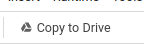


### Submission Instructions:
1. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
2. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and all the cells include their outputs

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
!pip install datasets
!pip install transformers
!pip install nltk
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('punkt_tab')
## If you're usig older version of nltk, you night need to use this lin instead:
# nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# The assignment zip includes 2 files you need to use:
# 'glove.npy' and 'vocab.json'.
# you can upload the directly to this session storage, using the "files" button on the left menu,
# and then the "upload" button on the top of the sidebar. This upload is only valid for each session,
# so if you restart the session you'll neeed to upload the files again

# If you prefer, You can download the files directly to the sessio using these three lines:
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
From (redirected): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn&confirm=t&uuid=161b1229-0431-4a45-a475-dbe928ce823e
To: /content/glove.npy
100%|██████████| 480M/480M [00:07<00:00, 61.0MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 26.9MB/s]


'vocab.json'

In [4]:
import numpy as np
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [6]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [7]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [8]:
from evaluate import load
metric = load("accuracy")

### If you're using older versions, use:
# metric = dataset.load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [9]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


## SECTION A - DAN implentation

In [10]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self): # YOU ARE ALSO ALLOWED TO ADD PARAMETER TO THE __INIT__
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))

          # YOUR CODE HERE
          print(self.embeddings.weight.shape)
          self.classifier = nn.Sequential(
              nn.Linear(300,512),
              nn.ReLU(),
              nn.Linear(512,512),
              nn.ReLU(),
              nn.Linear(512,2)
          )
          self.loss = nn.CrossEntropyLoss()

          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embedded = self.embeddings(input_ids) # Shape: [batch, seq_len, 300]

      masks_expanded = attention_masks.unsqueeze(-1).float()
      masked_embedded = embedded * masks_expanded

      sum_embeddings = masked_embedded.sum(dim=1)
      sum_masks = masks_expanded.sum(dim=1)
      avg = sum_embeddings / sum_masks

      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [11]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs=20, #must be at least 10. Lets try 20
                                  per_device_train_batch_size=30,
                                  per_device_eval_batch_size=30,
                                  learning_rate=5e-4,
                                  report_to='none',
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy",
                                  save_strategy="epoch",

                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  eval_strategy="epoch"
                                  ) # Older version might need 'evaluation_strateg' instead
model = DAN()



trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE
                 EarlyStoppingCallback(early_stopping_patience=3)
                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


torch.Size([400001, 300])


In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.487600,0.391167,0.825680
2,0.404500,0.443020,0.788880
3,0.396100,0.378313,0.833440
4,0.388600,0.403423,0.819280
5,0.384300,0.465063,0.785360
6,0.379000,0.396059,0.826080


TrainOutput(global_step=5004, training_loss=0.40046772658586693, metrics={'train_runtime': 292.6543, 'train_samples_per_second': 1708.501, 'train_steps_per_second': 56.996, 'total_flos': 0.0, 'train_loss': 0.40046772658586693, 'epoch': 6.0})

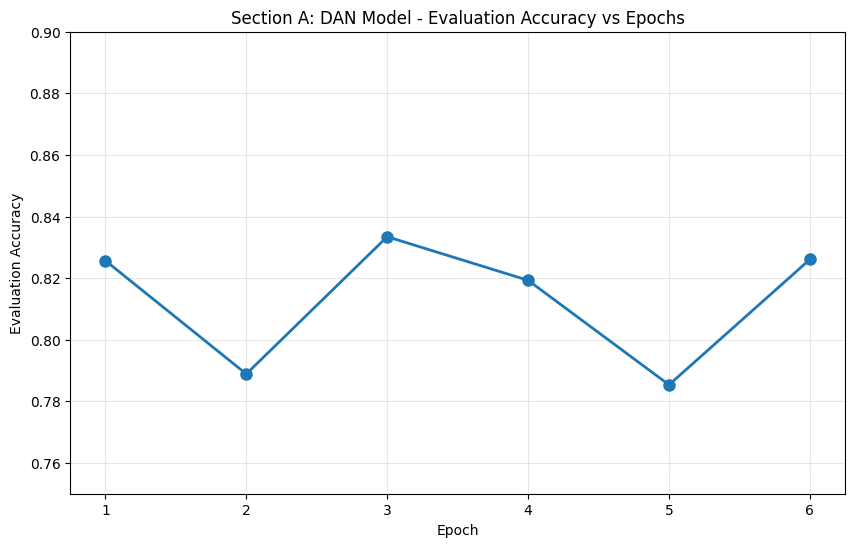

Best accuracy: 0.8334 at epoch 3.0


In [13]:
import matplotlib.pyplot as plt

# Extract metrics from training history
log_history = trainer.state.log_history

# Separate train and eval logs
eval_logs = [log for log in log_history if 'eval_accuracy' in log]
epochs = [log['epoch'] for log in eval_logs]
accuracies = [log['eval_accuracy'] for log in eval_logs]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel('Epoch')
plt.ylabel('Evaluation Accuracy')
plt.title('Section A: DAN Model - Evaluation Accuracy vs Epochs')
plt.grid(True, alpha=0.3)
plt.ylim([0.75, 0.90])
plt.show()

print(f"Best accuracy: {max(accuracies):.4f} at epoch {epochs[accuracies.index(max(accuracies))]}")

After some tweaking epoch 3 which is the best modal passees 83.5%, with 83.544% ^

## SECTION B - Trying drpout

In [ ]:
# YOUR CODE HERE
## SECTION B - Trying dropout
# Define DAN with word dropout support
class DAN(nn.Module):
  def __init__(self, word_dropout=0.0):
          super().__init__()
          self.num_labels = 2
          self.word_dropout = word_dropout
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))

          self.classifier = nn.Sequential(
              nn.Linear(300, 512),
              nn.ReLU(),
              nn.Linear(512, 512),
              nn.ReLU(),
              nn.Linear(512, 2)
          )
          self.loss = nn.CrossEntropyLoss()

  def forward(self, input_ids, attention_masks, labels=None, **kwargs):
      embedded = self.embeddings(input_ids)

      if self.training and self.word_dropout > 0:
          dropout_mask = torch.bernoulli(
              torch.full_like(attention_masks, 1 - self.word_dropout, dtype=torch.float)
          )
          masks_expanded = (attention_masks.float() * dropout_mask).unsqueeze(-1)
      else:
          masks_expanded = attention_masks.unsqueeze(-1).float()

      masked_embedded = embedded * masks_expanded
      sum_embeddings = masked_embedded.sum(dim=1)
      sum_masks = masks_expanded.sum(dim=1) + 1e-8
      avg = sum_embeddings / sum_masks

      res = self.classifier(avg)
      loss = self.loss(res, labels)
      return {"loss": loss, "logits": res}



Training with dropout=0.0
{'loss': 0.4866, 'grad_norm': 2.0570991039276123, 'learning_rate': 0.00048504196642685854, 'epoch': 0.5995203836930456}
{'eval_loss': 0.4331166744232178, 'eval_accuracy': 0.79992, 'eval_runtime': 12.962, 'eval_samples_per_second': 1928.717, 'eval_steps_per_second': 64.342, 'epoch': 1.0}
{'loss': 0.4199, 'grad_norm': 4.852978229522705, 'learning_rate': 0.0004700539568345324, 'epoch': 1.1990407673860912}
{'loss': 0.4042, 'grad_norm': 0.3194322884082794, 'learning_rate': 0.0004550659472422062, 'epoch': 1.7985611510791366}
{'eval_loss': 0.5045555830001831, 'eval_accuracy': 0.75212, 'eval_runtime': 15.8662, 'eval_samples_per_second': 1575.674, 'eval_steps_per_second': 52.564, 'epoch': 2.0}
{'loss': 0.3951, 'grad_norm': 2.9379472732543945, 'learning_rate': 0.0004400779376498801, 'epoch': 2.3980815347721824}
{'loss': 0.3929, 'grad_norm': 3.438077926635742, 'learning_rate': 0.00042508992805755395, 'epoch': 2.997601918465228}
{'eval_loss': 0.38387471437454224, 'eval_a

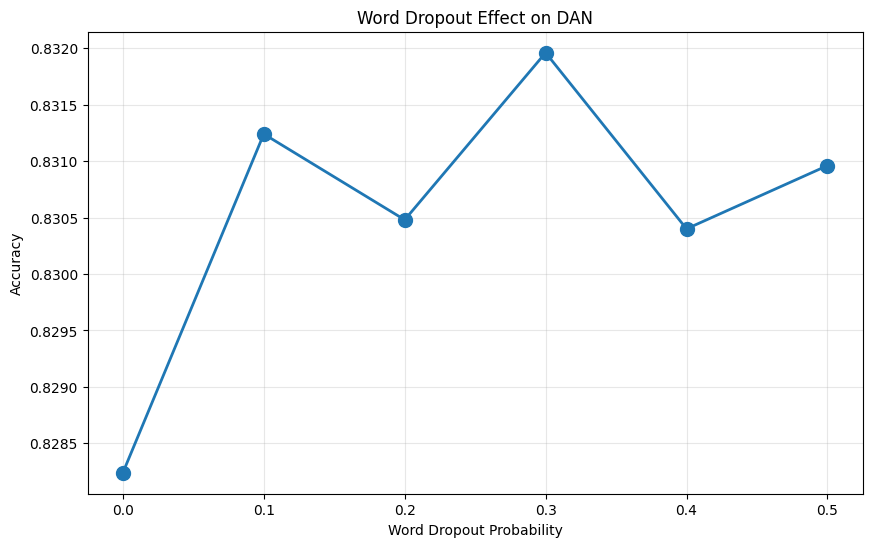

In [ ]:
# Test different dropout values
import matplotlib.pyplot as plt

dropout_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
results = []

for dropout_p in dropout_values:
    print(f"\nTraining with dropout={dropout_p}")

    model = DAN(word_dropout=dropout_p)
    trainer = Trainer(
        model=model,
        data_collator=co,
        args=training_args,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    results.append({
        'dropout': dropout_p,
        'accuracy': eval_results['eval_accuracy']
    })

    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")

best = max(results, key=lambda x: x['accuracy'])
print(f"\nBest: dropout={best['dropout']}, accuracy={best['accuracy']:.4f}")

plt.figure(figsize=(10, 6))
plt.plot([r['dropout'] for r in results], [r['accuracy'] for r in results],
         marker='o', linewidth=2, markersize=10)
plt.xlabel('Word Dropout Probability')
plt.ylabel('Accuracy')
plt.title('Word Dropout Effect on DAN')
plt.grid(True, alpha=0.3)
plt.show()


## SCETION C - Different Layer num

**Before you start training, think about when will
we start seeing the effect of diminishing returns, are the results the way you expected them to be?**

Before starting training, I anticipated that because the task is binary classification and determining positivity does not seem too complex, we would see diminishing returns after 2 layers. The actual results were even more dramatic performance stagnated and even declined after just 1 hidden layer. It seems that one layer is enough to "learn" this problem. This indicates that over-parameterizing the model is undesirable for this task, likely due to overfitting or optimization difficulties with unnecessary depth.

**Did the linear model outperform the model with 4 hidden layers?**
Seems to be a typo and meaning 3 hidden layers, yes as discussed above the linear model outperfomed the model with 3 layers, this makes sense because 3 layers seem intutivly too complicated for the task

In [ ]:
# YOUR CODE HERE
## SECTION C - SCETION C - Different Layer num
# Define DAN with Different Layer support
import torch
from torch import nn
import numpy as np
class DAN(nn.Module):
  def __init__(self, num_layers=2, hidden_dim=512):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))

          if num_layers == 0:
              self.classifier = nn.Linear(300, 2)
          else:
              layers = []
              layers.append(nn.Linear(300, hidden_dim))
              layers.append(nn.ReLU())

              for _ in range(num_layers - 1):
                  layers.append(nn.Linear(hidden_dim, hidden_dim))
                  layers.append(nn.ReLU())

              layers.append(nn.Linear(hidden_dim, 2))
              self.classifier = nn.Sequential(*layers)

          self.loss = nn.CrossEntropyLoss()

  def forward(self, input_ids, attention_masks, labels=None, **kwargs):
      embedded = self.embeddings(input_ids)
      masks_expanded = attention_masks.unsqueeze(-1).float()
      masked_embedded = embedded * masks_expanded
      sum_embeddings = masked_embedded.sum(dim=1)
      sum_masks = masks_expanded.sum(dim=1) + 1e-8
      avg = sum_embeddings / sum_masks

      res = self.classifier(avg)
      loss = self.loss(res, labels)
      return {"loss": loss, "logits": res}




Training with 0 hidden layers


Epoch,Training Loss,Validation Loss,Accuracy
1,0.663200,0.621134,0.692240
2,0.597900,0.583435,0.728760
3,0.560300,0.557565,0.749400
4,0.547500,0.538690,0.760800
5,0.527700,0.523794,0.770920
6,0.511400,0.511372,0.779280
7,0.503900,0.502125,0.783560
8,0.493000,0.494351,0.787840
9,0.485400,0.488055,0.790800
10,0.478400,0.482895,0.792680


Accuracy: 0.8020

Training with 1 hidden layers


Epoch,Training Loss,Validation Loss,Accuracy
1,0.530400,0.412830,0.815880
2,0.400200,0.397914,0.822320
3,0.386200,0.389531,0.827200
4,0.380300,0.380518,0.830520
5,0.379400,0.413777,0.808760
6,0.375800,0.382013,0.830600
7,0.370000,0.381884,0.829960
8,0.366000,0.388697,0.826080
9,0.365900,0.372719,0.837120
10,0.356700,0.373429,0.835680


Accuracy: 0.8371

Training with 2 hidden layers


Epoch,Training Loss,Validation Loss,Accuracy
1,0.486300,0.407678,0.814040
2,0.406400,0.413977,0.808680
3,0.393400,0.377795,0.834040
4,0.388800,0.401987,0.820640
5,0.384000,0.469147,0.785720
6,0.379900,0.389832,0.828280


Accuracy: 0.8340

Training with 3 hidden layers


Epoch,Training Loss,Validation Loss,Accuracy
1,0.483000,0.441850,0.795280
2,0.414500,0.382207,0.831560
3,0.400000,0.377223,0.833680
4,0.397000,0.416742,0.809840
5,0.389600,0.459404,0.789680
6,0.382900,0.395007,0.826080


Accuracy: 0.8337

Best: {'layers': 1, 'accuracy': 0.83712}


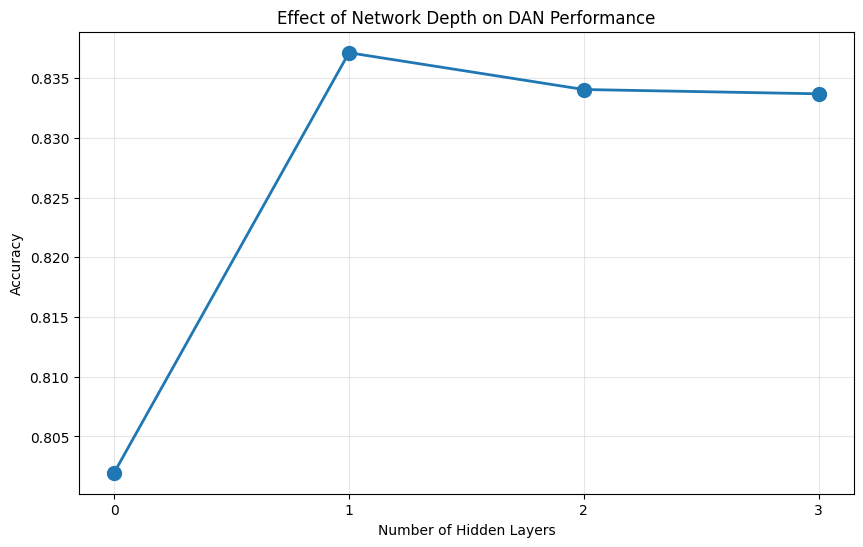

In [ ]:
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import TrainingArguments

layer_counts = [0, 1, 2, 3]
results = []

for num_layers in layer_counts:
    print(f"\nTraining with {num_layers} hidden layers")

    model = DAN(num_layers=num_layers, hidden_dim=512)
    trainer = Trainer(
        model=model,
        data_collator=co,
        args=training_args,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_results = trainer.evaluate()

    results.append({
        'layers': num_layers,
        'accuracy': eval_results['eval_accuracy']
    })

    print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")

print(f"\nBest: {max(results, key=lambda x: x['accuracy'])}")

plt.figure(figsize=(10, 6))
plt.plot([r['layers'] for r in results], [r['accuracy'] for r in results],
         marker='o', linewidth=2, markersize=10)
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.title('Effect of Network Depth on DAN Performance')
plt.xticks([0, 1, 2, 3])
plt.grid(True, alpha=0.3)
plt.show()

## SECTION D - Activations

In [17]:
import torch
from torch import nn
import numpy as np

class DAN(nn.Module):
  def __init__(self, activation='relu'):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))

          act_map = {
              'relu': nn.ReLU(),
              'tanh': nn.Tanh(),
              'gelu': nn.GELU()
          }
          act_fn = act_map[activation]

          self.classifier = nn.Sequential(
              nn.Linear(300, 512),
              act_fn,
              nn.Linear(512, 512),
              act_fn,
              nn.Linear(512, 2)
          )
          self.loss = nn.CrossEntropyLoss()

  def forward(self, input_ids, attention_masks, labels=None, **kwargs):
      embedded = self.embeddings(input_ids)
      masks_expanded = attention_masks.unsqueeze(-1).float()
      masked_embedded = embedded * masks_expanded
      sum_embeddings = masked_embedded.sum(dim=1)
      sum_masks = masks_expanded.sum(dim=1) + 1e-8
      avg = sum_embeddings / sum_masks

      res = self.classifier(avg)
      loss = self.loss(res, labels)
      return {"loss": loss, "logits": res}

activations = ['relu', 'tanh', 'gelu']
results = []
results_over_time = {}

for act in activations:
    print(f"\nTraining with {act.upper()} activation")

    model = DAN(activation=act)
    trainer = Trainer(
        model=model,
        data_collator=co,
        args=training_args,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()  # Train once
    eval_results = trainer.evaluate()

    # Save final accuracy
    results.append({
        'activation': act.upper(),
        'accuracy': eval_results['eval_accuracy']
    })

    # Save epoch-by-epoch history
    log_history = trainer.state.log_history
    eval_logs = [log for log in log_history if 'eval_accuracy' in log]
    results_over_time[act] = {
        'epochs': [log['epoch'] for log in eval_logs],
        'accuracies': [log['eval_accuracy'] for log in eval_logs]
    }

    print(f"Final Accuracy: {eval_results['eval_accuracy']:.4f}")

print(f"\nBest: {max(results, key=lambda x: x['accuracy'])}")


Training with RELU activation


Epoch,Training Loss,Validation Loss,Accuracy
1,0.488300,0.433781,0.798960
2,0.407400,0.501047,0.752960
3,0.391200,0.379110,0.832760
4,0.389100,0.398588,0.821400
5,0.381900,0.445211,0.796760
6,0.379100,0.391225,0.828160


Final Accuracy: 0.8328

Training with TANH activation


Epoch,Training Loss,Validation Loss,Accuracy
1,0.477600,0.402529,0.819600
2,0.411700,0.502932,0.747200
3,0.398100,0.380122,0.832920
4,0.394900,0.393918,0.826440
5,0.390300,0.413196,0.812800
6,0.387900,0.407777,0.820680


Final Accuracy: 0.8329

Training with GELU activation


Epoch,Training Loss,Validation Loss,Accuracy
1,0.481100,0.395902,0.823480
2,0.403800,0.413788,0.809000
3,0.391800,0.381505,0.832400
4,0.389400,0.399159,0.822920
5,0.387200,0.410909,0.813800
6,0.384800,0.394379,0.828280


Final Accuracy: 0.8324

Best: {'activation': 'TANH', 'accuracy': 0.83292}


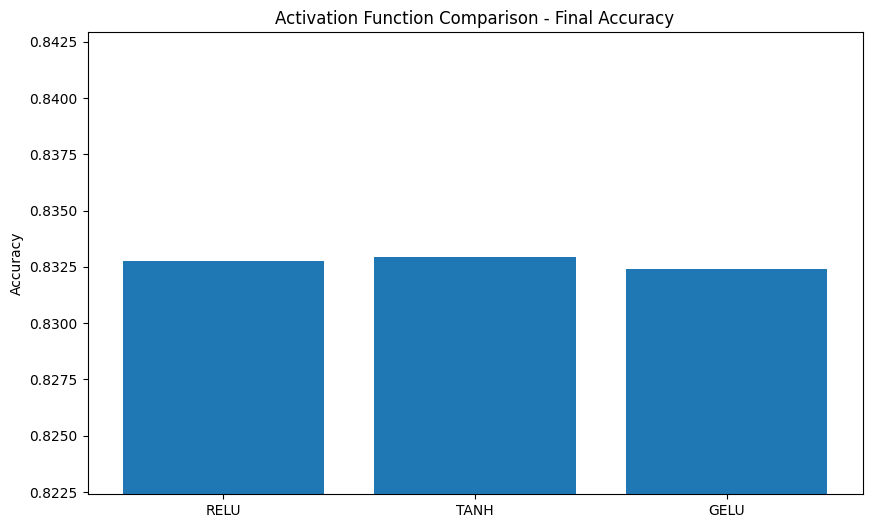

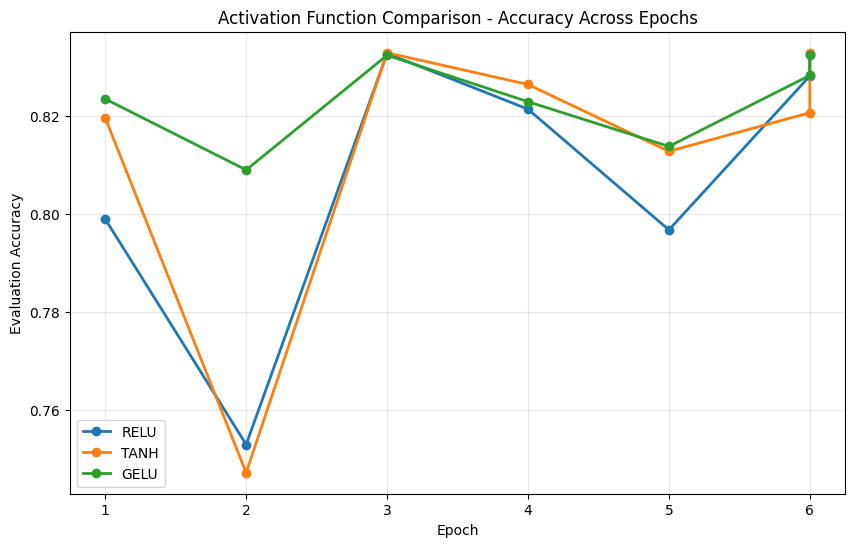

In [18]:


import matplotlib.pyplot as plt

# Plot 1: Bar chart of final accuracy
plt.figure(figsize=(10, 6))
acts = [r['activation'] for r in results]
accs = [r['accuracy'] for r in results]
plt.bar(acts, accs)
plt.ylabel('Accuracy')
plt.title('Activation Function Comparison - Final Accuracy')
plt.ylim([min(accs)-0.01, max(accs)+0.01])
plt.show()

# Plot 2: Line chart of accuracy across epochs
plt.figure(figsize=(10, 6))
for act in activations:
    plt.plot(
        results_over_time[act]['epochs'],
        results_over_time[act]['accuracies'],
        marker='o',
        label=act.upper(),
        linewidth=2,
        markersize=6
    )
plt.xlabel('Epoch')
plt.ylabel('Evaluation Accuracy')
plt.title('Activation Function Comparison - Accuracy Across Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**What have you learned from this experiment?**

The results are:
- ReLU achieved 83.28% accuracy
- Tanh achieved 83.29% accuracy (best)
- GELU achieved 83.24% accuracy

The GELU activation function demonstrated the most consistent training behavior, while ReLU and Tanh exhibited more significant fluctuations across epochs. However, when using early stopping to select the best performing epoch, all three activation functions ultimately achieved virtually identical accuracy.

This suggests that for binary classification on IMDB, the choice of activation function has minimal impact on final performance. All three remain excellent choices. The similarity in performance indicates that the task doesnt require sophisticated activation functions.




## Section E - Sample 5 examples

Let's recreate the best Model from section A

In [19]:

import torch
from torch import nn
import numpy as np
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

class DAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_labels = 2
        self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))

        self.classifier = nn.Sequential(
            nn.Linear(300, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
        self.loss = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_masks, labels=None, **kwargs):
        embedded = self.embeddings(input_ids)
        masks_expanded = attention_masks.unsqueeze(-1).float()
        masked_embedded = embedded * masks_expanded
        sum_embeddings = masked_embedded.sum(dim=1)
        sum_masks = masks_expanded.sum(dim=1) + 1e-8
        avg = sum_embeddings / sum_masks

        res = self.classifier(avg)
        loss = self.loss(res, labels)
        return {"loss": loss, "logits": res}

training_args = TrainingArguments(
    "DAN_best",
    num_train_epochs=20,
    per_device_train_batch_size=30,
    per_device_eval_batch_size=30,
    learning_rate=5e-4,
    report_to='none',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    save_total_limit=2,
    log_level="error",
    eval_strategy="epoch"
)

model = DAN()
trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
eval_results = trainer.evaluate()
print(f"Best model accuracy: {eval_results['eval_accuracy']:.4f}")

predictions = trainer.predict(small_eval_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

misclassified_indices = np.where(pred_labels != true_labels)[0]
print(f"Total misclassified: {len(misclassified_indices)}")

import random
random.seed(42)
sample_indices = random.sample(list(misclassified_indices), 5)

for i, idx in enumerate(sample_indices, 1):
    true_label = "Positive" if true_labels[idx] == 1 else "Negative"
    pred_label = "Positive" if pred_labels[idx] == 1 else "Negative"
    text = raw_datasets['test'][int(idx)]['text']

    print(f"\nExample {i}")
    print(f"True Label: {true_label}")
    print(f"Predicted: {pred_label}")
    print(f"Text: {text}\n")
    print("-" * 80)


{'loss': 0.4877, 'grad_norm': 2.0284101963043213, 'learning_rate': 0.00048504196642685854, 'epoch': 0.5995203836930456}
{'eval_loss': 0.39386117458343506, 'eval_accuracy': 0.82272, 'eval_runtime': 16.5269, 'eval_samples_per_second': 1512.684, 'eval_steps_per_second': 50.463, 'epoch': 1.0}
{'loss': 0.4148, 'grad_norm': 4.04741907119751, 'learning_rate': 0.0004700539568345324, 'epoch': 1.1990407673860912}
{'loss': 0.4049, 'grad_norm': 0.47184106707572937, 'learning_rate': 0.0004550659472422062, 'epoch': 1.7985611510791366}
{'eval_loss': 0.41962867975234985, 'eval_accuracy': 0.80376, 'eval_runtime': 12.8439, 'eval_samples_per_second': 1946.456, 'eval_steps_per_second': 64.934, 'epoch': 2.0}
{'loss': 0.3959, 'grad_norm': 2.6122026443481445, 'learning_rate': 0.0004400779376498801, 'epoch': 2.3980815347721824}
{'loss': 0.392, 'grad_norm': 3.5669615268707275, 'learning_rate': 0.00042508992805755395, 'epoch': 2.997601918465228}
{'eval_loss': 0.3855229616165161, 'eval_accuracy': 0.82628, 'eval_

**Try to explain shortly why the model classified it incorrectly**

My assessment of why it classifed incorrectly:

Example 1:
The review mentions "intriguing final act" and "well-played scene" which sound positive. The model averaged these with the negative parts and got confused about the overall critical tone.

Example 2:
The reviewer talks about "great holiday comedy" and "original Christmas Vacation" early on. The model didn't realize these positive phrases refer to a different movie, not the one being reviewed.

Example 3:
Words like "melancholic" and "suffered" have negative associations even though the review is praising the film. The model weighted these words too heavily despite the clear positive language like "excellent" and "moving."

Example 4:
The review says things like "not an Oscar winner" and "technically horrible" but clearly enjoyed it as a fun bad movie. The model can't detect this "so bad it's good" sentiment and just sees the negative words.

Example 5:
Most of the review lists problems and inconsistencies in detail. Only at the end does it mention anything positive. The model averaged all the criticism and missed that the reviewer still found it entertaining.

